# COURSE: A deep understanding of deep learning
## SECTION: ANNs
### LECTURE: Multilayer ANNs
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

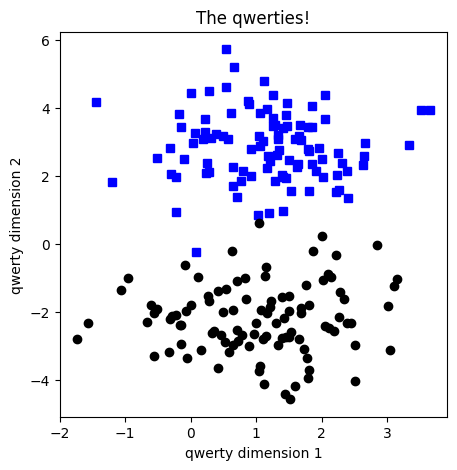

In [2]:
# create data

nPerClust = 100
blur = 1

A = [ 1,  3 ]
B = [ 1, -2 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust) * blur , A[1] + np.random.randn(nPerClust) * blur ]
b = [ B[0] + np.random.randn(nPerClust) * blur , B[1] + np.random.randn(nPerClust) * blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatanate into a matrix
data_np = np.hstack((a, b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Functions to build and train the model

In [3]:
class ANNmodel_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(2, 16)

    ### hidden layers
    self.fc1    = nn.Linear(16, 1)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer

    ### output layer
    self.output = nn.Linear(1, 1)

  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )

    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function
    else:
      # hidden layer 1
      x = F.relu( self.fc1(x) )

    # output layer
    return F.sigmoid(self.output(x))


def createANNmodel(learningRate):
  model = ANNmodel_withBNorm()

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)

  # model output
  return model, lossfun, optimizer

In [4]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data, True)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  # final forward pass
  predictions = ANNmodel(data, True)

  # compute the predictions and report accuracy
  # NOTE: Wasn't this ">0" previously?!?!
  totalacc = 100*torch.mean(((predictions>.5) == labels).float())

  return losses,predictions,totalacc

# Test the new code by running it once

Final accuracy: 99%


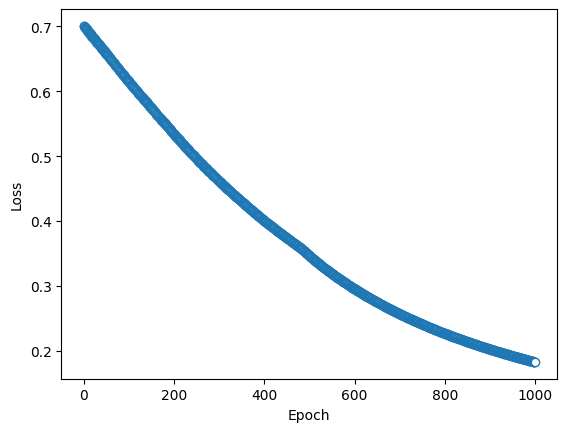

In [5]:
# create everything
ANNclassify, lossfun, optimizer = createANNmodel(.01)

# run it
losses, predictions, totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor = 'w', linewidth = .1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

# Now for the real test (varying learning rates)

In [6]:
# learning rates
learningrates = np.linspace(.001, .1,50)

# initialize
accByLR = []
allLosses = np.zeros((len(learningrates), numepochs))


# the loop
for i,lr in enumerate(learningrates):

  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()


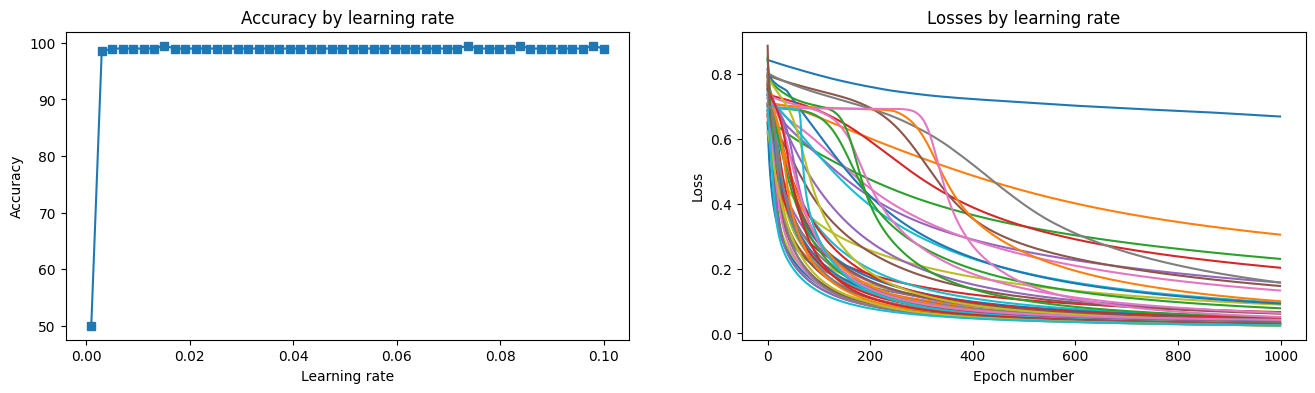

In [7]:
# plot the results
fig,ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(learningrates,accByLR, 's-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [8]:
accByLR

[tensor(50.),
 tensor(98.5000),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.5000),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.5000),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.5000),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.),
 tensor(99.5000),
 tensor(99.)]

In [9]:
sum(torch.tensor(accByLR) > 70) / len(accByLR)

tensor(0.9800)

# Additional explorations

In [10]:
# 1) The code creates a model with 16 hidden units. Notice where the two "16"s appear when constructing the model. 
#    Recreate the model using 32 hidden units. Does that help with the issue of models getting stuck in local minima?
# 
# 2) Adjust the code to create two hidden layers. The first hidden layer should have 16 hidden units and the second 
#    hidden layer shuold have 32 units. What needs to change in the code to make the numbers match to prevent coding errors?
# 